## Preprocess data from data/twitter_poll.csv

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [ ]:
twitter_poll_df = pd.read_csv('')

In [2]:
twitter_poll_df = pd.read_csv('data/obama_aggregate.csv')
twitter_poll_df.drop(['date', 'Unnamed: 0'], axis=1, inplace=True)
twitter_poll_df.head()

,replies,retweets,favorites,approving
0,6175,13945,76360,57
1,5601,3954,24773,53
2,6368,4581,29044,53
3,3928,9502,46260,53
4,1288,6150,25260,53


## Viualization
Now might be the most convenient time to do some preliminary feature exploration!

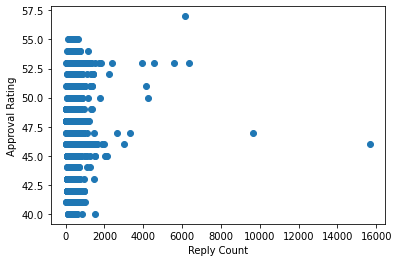

In [3]:
f = plt.figure()
plt.scatter(twitter_poll_df['replies'], twitter_poll_df['approving'])
plt.xlabel('Reply Count')
plt.ylabel('Approval Rating')
plt.show()

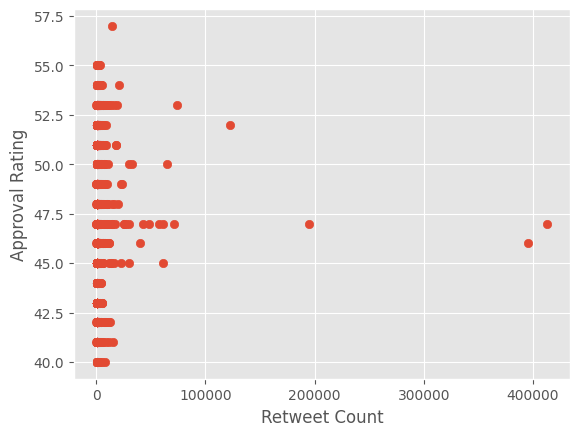

In [200]:
f = plt.figure()
plt.scatter(twitter_poll_df['retweets'], twitter_poll_df['approving'])
plt.xlabel('Retweet Count')
plt.ylabel('Approval Rating')
plt.show()

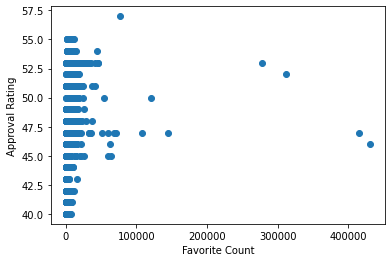

In [4]:
f = plt.figure()
plt.scatter(twitter_poll_df['favorites'], twitter_poll_df['approving'])
plt.xlabel('Favorite Count')
plt.ylabel('Approval Rating')
plt.show()

## Get training and test set

In [5]:
from sklearn.model_selection import train_test_split

approve_estimate = twitter_poll_df['approving']
twitter_poll_df.drop('approving', axis=1, inplace=True)
X = twitter_poll_df
y = approve_estimate.values
X_train, X_test, y_train, y_test = train_test_split(twitter_poll_df, approve_estimate.values, test_size=0.2)

## Normalization
So at this point, favorites and retweets are the features, $X_{rpc}$, $X_{rtc}$, and $X_{fvc}$ that predict the approval estimate, $Y$. I want to normalize $X_{rpc}$, $X_{rtc}$, and $X_{fvc}$ since retweets are almost always less than favorites.

In [6]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)
X = sc.transform(X)
print(X_train)
print(X_test)
print(y_train)

[[-0.47508097 -0.14944239 -0.21967696]
 [ 1.41736323 -0.12689305 -0.03723582]
 [-0.43162645 -0.14206076 -0.22717454]
 ...
 [ 0.06375504 -0.08695139 -0.08302987]
 [ 0.29406398 -0.02516822  0.02076018]
 [ 0.33317304 -0.13346572 -0.22077954]]
[[-0.47942642 -0.17168837 -0.23922947]
 [-0.21218114 -0.14145405 -0.16954607]
 [-0.0905085  -0.08776034  0.02215678]
 ...
 [ 0.53306382 -0.1367015  -0.07075442]
 [-0.46204461  0.00162808 -0.00092401]
 [ 0.11807318 -0.11890471 -0.0757528 ]]
[42 51 46 ... 45 47 41]


## Model selection hunt!
Note: Both regression and classification models will work due to the discrete but numeric nature of the dataset


### Linear Models

In [12]:
from sklearn.linear_model import LinearRegression

regr = LinearRegression()

t0 = time.time()
regr.fit(X_train, y_train)
regr_time = time.time() - t0
y_pred = regr.predict(X_test)

### Linear regression metrics

Some observations:
* Coefficient of determination is negative, which originally confused me but after looking at the sklearn.metrics.r2_score documentation I see "it need not actually be the square of a quantity R", but this is indicative of a poor model

In [13]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score

print('Coefficients: \n', regr.coef_)
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))
print('Mean Absolute Error: %.2f' % mean_absolute_error(y_test, y_pred))
print('Accuracy: %.2f' % regr.score(X_test, y_test))
print('Time elapsed: %.2f' % regr_time)

Coefficients: 
 [ 0.33689555 -1.57929151  1.64329872]
Mean squared error: 10.00
Coefficient of determination: 0.06
Mean Absolute Error: 2.50
Accuracy: 0.06
Time elapsed: 0.00


### Logistic regression metrics

By default LogisticRegression uses an optimization algorithm that aproximates the Broyden-Fletcher-Goldfarb-Shanno algorithm. 
<br/><br/> Note: Logistic regression is actually a classification method, but since my data is discrete integers, it will still work as a multinominal classification model. 

Observations:
* Highly reduce mean squared error, and coefficient of determination is at least positive now.
* Still does not seem like a very good model

In [38]:
from sklearn.linear_model import LogisticRegression

log_regr = LogisticRegression()
log_regr.fit(X_train, y_train)
y_pred = log_regr.predict(X_test)

C:\Users\kaibo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [39]:
print('Coefficients: \n', log_regr.coef_)
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))
print('Accuracy: %.2f' % log_regr.score(X_test, y_test))

Coefficients: 
 [[ 0.67653858  0.21616126 -1.30009515]
 [ 0.69267091  0.71909488 -4.30808196]
 [-0.07627195  3.56655847 -4.6376122 ]
 [-0.18774845 -0.01915228 -4.80381382]
 [ 0.48341058 -0.71611128 -1.08110489]
 [-0.12147153  1.99912278 -0.99850682]
 [ 0.13568588  2.97300801 -2.3544056 ]
 [-0.49493501  2.20592008 -0.68250791]
 [-1.12421409 -0.49274707  2.06367367]
 [-1.05701366  2.14267585 -0.52740689]
 [-0.16170094 -0.95205346  2.54618002]
 [-0.10321522 -2.90024984  3.29375241]
 [-0.13898602 -2.67329269  3.52010506]
 [ 0.23946203 -3.07565915  3.61509796]
 [ 0.03480691 -1.22065589  2.54607019]
 [ 0.12282319 -0.50022744  1.43497316]
 [ 1.08015881 -1.27239221  1.67368278]]
Mean squared error: 11.30
Coefficient of determination: 0.05
Accuracy: 0.22


### Compute metrics for regression function for code reuse

In [20]:
def compute_metrics(regr, X_test, y_test, X, y, time):
    y_pred = regr.predict(X_test)
    print('Mean Squared Error: %.2f' % mean_squared_error(y_pred, y_test))
    print('Mean Absolute Error: %.2f' % mean_absolute_error(y_pred, y_test))
    print('Time to train model: %.2f seconds' % time)
    print('R2 Score: %.2f' % r2_score(y_pred, y_test))
    print('Estimator Score: %.2f' % regr.score(X_test, y_test))

### Generalized Linear Regression
From scikit-learn: GLM extends linear models in two ways. First, the predicted values $\hat{y}$ are linked to a linear combination of the input variables X via an inverse link function h as $$\hat{y}(w, X) = h(Xw).$$ Secondly, the squared loss function is replaced by the unit deviance d of a distribution in the exponential family (or more precisely, a reproductive exponential dispersion model).<br/> The minimization model becomes: $$\min_{w}\frac{1}{2n_{samples}}\sum_{i}d(y_{i}, \hat{y_{i}}) + \frac{\alpha}{2}||w||_{2}$$

Since the target values are positive valued and skewed, I will try GLM with Gamma deviance. Since $X$ is standardized and the Gamma distribution does not support negative values, I will set link='log' so that the inverse link function will guarantee non-negativeness.

In [261]:
from sklearn.linear_model import TweedieRegressor
regr = TweedieRegressor(alpha=0.5, power=2, link='log')
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)
print(X)

[[ 1.16288579e+01  9.33519502e-01  4.59534381e+00]
 [ 1.04871882e+01  1.50992479e-01  1.32341795e+00]
 [ 1.20127294e+01  2.00101121e-01  1.59430782e+00]
 ...
 [-2.43313864e-01 -1.38255073e-01 -2.02089647e-01]
 [ 3.59344545e-01 -1.34613153e-03 -1.03653434e-01]
 [ 5.06528447e-01 -6.13416975e-02 -1.86867552e-01]]


In [262]:
compute_metrics(regr, X_test, y_test, X, y)

Mean Squared Error 12.00
Neg Mean Squared Error -16.87
Coefficient of Determination -9.46
[-18.8878719   -0.47282613  -4.64668013  -0.12797178 -20.04404961]
Cross validation score -8.84


D^2 score is the percentage of deviance explained, defined to be $$D^2 = 1 - \frac{D(y_{true},y_{pred})}{D_{null}}$$ So this prior result says about 2% of the deviance from the model's prediction to the true value is explained by random error. Not looking very good for the features :( <br/><br/>
Alpha is a constant that multiplies the penalty term ($\frac{1}{2}||w||_{2}$, or L2 norm) and I chose alpha arbitrarily, so I will try an incremental approach to choosing this hyperparameter

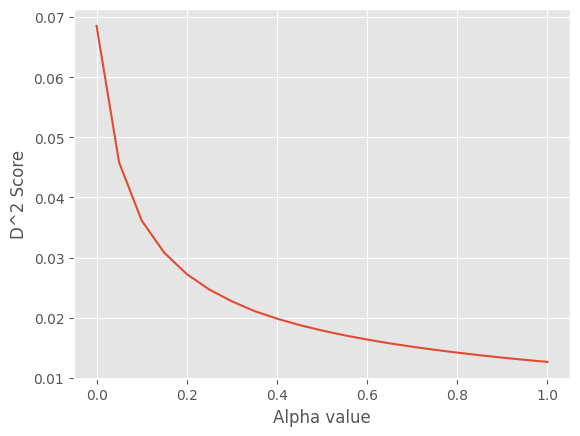

Max value of D^2 is 0.07 achieved at alpha 0.00


In [42]:
max_score = -1000
max_alpha = -1000
cur_alpha = 0

score_list = []
alpha_list = np.linspace(0,1,21)

while cur_alpha < 1.05:
    regr = TweedieRegressor(alpha=cur_alpha, power=2, link='log')
    regr.fit(X_train, y_train)
    cur_score = regr.score(X_test, y_test)
    if(cur_score > max_score):
        max_score = cur_score
        max_alpha = cur_alpha

    score_list.append(cur_score)
    cur_alpha += 0.05

f = plt.figure()
plt.plot(alpha_list, score_list)
plt.xlabel("Alpha value")
plt.ylabel("D^2 Score")
plt.show()
print("Max value of D^2 is %.2f achieved at alpha %.2f" % (max_score,max_alpha))

We can see that $D^2$ is a convex function with respect to $\alpha$, it is intuitive that this is a monotonically decreasing function, considering that the L2 penalization is designed to penalize model complexity.
<br/><br/>
Still though, with an $\alpha$ of 0, we can see that even without penalizing complexity we can only achieve a $D^2$ score of 8%. Time to look at other models!

## Linear models: perliminary conclusion
So I have went ahead and played around with a few other linear models such as BayesianRegression and StochasticGradientDescent, but all scoring metrics have remained under 10%, which leads me to believe that a linear model is not a good choice for this problem. So I will move forward!

## Support Vector Regression

SVR is implemented by solving the following problem:
## $$\min_{w,b,\zeta,\zeta*} \frac{1}{2}w^{T}w + C\sum_{i=1}^{n}(\zeta_{i} + \zeta^{*}_{i})$$
## subject to $$y_{i} - w^{T}\phi(x_{i}) - b \leq \epsilon + \zeta_{i},$$         
##              $$w^{T}\phi(x_{i}) + b - y_{i} \leq \epsilon + \zeta^{*}_{i}$$
##              $$\zeta_{i},\zeta^{*}_{i} \geq 0, i = 1,...,n$$
Note the hyperparameters C and $\epsilon$ that must be chosen. I will use sklearn's GridSearchCV to find these parameters, this function takes a long time, as it is a brute force method. First I will run SVM with default values and then fine tune via GridSearchCV.

In [21]:
from sklearn import svm

regr = svm.SVR()
t0 = time.time()
regr.fit(X_train, y_train)
regr_time = time.time() - t0
compute_metrics(regr, X_test, y_test, X, y, regr_time)

Mean Squared Error: 6.78
Mean Absolute Error: 2.01
Time to train model: 0.17 seconds
R2 Score: -1.92
Estimator Score: 0.36


With just the default values of support vector regression the R^2 value is 0.37, significantly higher than any of the linear model scores. 

In [44]:
from sklearn.model_selection import GridSearchCV

parameters = {'kernel': ['rbf'], 'C':[1, 10, 100, 1000, 5000, 10000], 'gamma': [1e-4, 1e-3, 1e-2, 1e-1], 'epsilon': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}

regr = svm.SVR()
#regr.fit(X_train, y_train)
clf = GridSearchCV(regr, parameters)
clf.fit(X_train, y_train)
clf.best_params_

#print("R^2 score: %.2f" % regr.score(X_test, y_test))

{'C': 1000, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}

In [23]:
regr = svm.SVR(kernel='rbf', C=1000, gamma=0.1, epsilon=0.1)
t0 = time.time()
regr.fit(X_train, y_train)
regr_time = time.time() - t0
compute_metrics(regr, X_test, y_test, X, y, regr_time)

Mean Squared Error: 5.85
Mean Absolute Error: 1.89
Time to train model: 0.38 seconds
R2 Score: -0.13
Estimator Score: 0.45


## Nearest Neighbors Regression

In [24]:
from sklearn.neighbors import KNeighborsRegressor

regr = KNeighborsRegressor(weights='distance')
t0 = time.time()
regr.fit(X_train, y_train)
regr_time = time.time() - t0
compute_metrics(regr, X_test, y_test, X, y, regr_time)

Mean Squared Error: 5.45
Mean Absolute Error: 1.78
Time to train model: 0.00 seconds
R2 Score: 0.19
Estimator Score: 0.49


In [27]:
from sklearn.model_selection import GridSearchCV
parameters={'weights':('uniform','distance'), 'n_neighbors':[2,5,10,12,13,14,15,16,17,20,23]}
clf = GridSearchCV(regr, parameters)
clf.fit(X_train, y_train)
clf.best_params_

{'n_neighbors': 14, 'weights': 'distance'}

In [28]:
regr = KNeighborsRegressor(weights='distance', n_neighbors=14)
t0 = time.time()
regr.fit(X_train, y_train)
regr_time = time.time() - t0
compute_metrics(regr, X_test, y_test, X, y, regr_time)


Mean Squared Error: 5.15
Mean Absolute Error: 1.76
Time to train model: 0.00 seconds
R2 Score: 0.03
Estimator Score: 0.52


## Random Forest Regression

In [32]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(criterion='mae', max_features='sqrt', random_state=1, min_samples_split=4)

parameters={
    'n_estimators':[350,450,850]
     }
clf = GridSearchCV(regr, parameters, verbose=3, n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_params_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


{'n_estimators': 850}

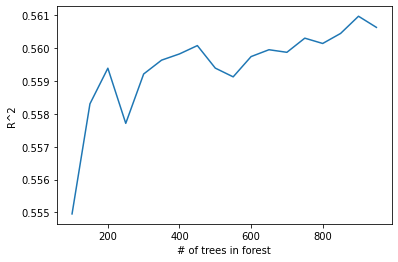

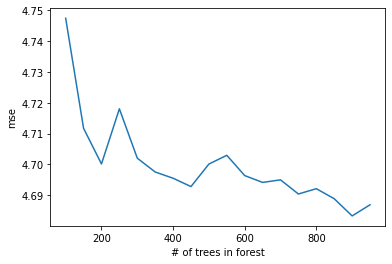

In [41]:
n_estimators_list = [a for a in range(100, 1000, 50)]
score_list = []
mse_list = []
for a in n_estimators_list:
    regr = RandomForestRegressor(n_estimators=a,criterion='mae', max_features='sqrt', random_state=1, min_samples_split=4)
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    mse_list.append(mean_squared_error(y_pred, y_test))
    score_list.append(regr.score(X_test,y_test))

f = plt.figure()
plt.plot(n_estimators_list, score_list)
plt.xlabel('# of trees in forest')
plt.ylabel('R^2')
plt.show()

f = plt.figure()
plt.plot(n_estimators_list, mse_list)
plt.xlabel('# of trees in forest')
plt.ylabel('mse')
plt.show()

In [42]:
n_estimators_list = [a for a in range(100, 5000, 100)]
score_list = []
mse_list = []
for a in n_estimators_list:
    regr = RandomForestRegressor(n_estimators=a,criterion='mae', max_features='sqrt', random_state=1, min_samples_split=4)
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    mse_list.append(mean_squared_error(y_pred, y_test))
    score_list.append(regr.score(X_test,y_test))

f = plt.figure()
plt.plot(n_estimators_list, score_list)
plt.xlabel('# of trees in forest')
plt.ylabel('R^2')
plt.show()

f = plt.figure()
plt.plot(n_estimators_list, mse_list)
plt.xlabel('# of trees in forest')
plt.ylabel('mse')
plt.show()

KeyboardInterrupt: 

In [33]:

regr = RandomForestRegressor(n_estimators=850,criterion='mae', max_features='sqrt', random_state=1, min_samples_split=4)
t0 = time.time()
regr.fit(X_train, y_train)
regr_time = time.time() - t0
compute_metrics(regr, X_test, y_test, X, y, regr_time)

Mean Squared Error: 4.69
Mean Absolute Error: 1.69
Time to train model: 30.09 seconds
R2 Score: 0.19
Estimator Score: 0.56


## Neural network model: multi-layer perceptron regressor
Alright this is the last big thing I will try, because it is interesting and with default values the model receives a 0.43 score and with undirected tuning we see a score of 0.57. I have done some reading trying to find ways to pick the different hyperparameters of a neural network.

In [35]:
from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(random_state=1, max_iter=1000, learning_rate='adaptive', solver='sgd', activation='tanh', alpha=1e-5)


In [143]:
parameters = {
    'hidden_layer_sizes': [(50, 50, 50), (100, 50), (34, 32,58)],
    'learning_rate_init': [0.005],
    'momentum': [0.802, 0.8, 0.798]
}
clf = GridSearchCV(regr, parameters, n_jobs=-1, verbose=3)
clf.fit(X_train, y_train)
clf.best_params_


Fitting 5 folds for each of 9 candidates, totalling 45 fits


{'hidden_layer_sizes': (34, 32, 58),
 'learning_rate_init': 0.005,
 'momentum': 0.802}

In [36]:
regr = MLPRegressor(random_state=1, max_iter=600, hidden_layer_sizes=(34,32,58),
                    activation='tanh', solver='sgd', alpha=1e-5,
                    learning_rate='adaptive', momentum=0.802, learning_rate_init=0.005)
t0 = time.time()
regr.fit(X_train, y_train)
regr_time = time.time() - t0


In [37]:
compute_metrics(regr, X_test, y_test, X, y, regr_time)

Mean Squared Error: 4.84
Mean Absolute Error: 1.74
Time to train model: 5.86 seconds
R2 Score: 0.21
Estimator Score: 0.55
